# Preset and definition of variables

In [197]:
import os

import mne_nirs
import mne_nirs.io
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

import mne_bids.stats

import mne
import mne.io

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns



%matplotlib inline 

# 0. Select data

Load data / epochs / GLM LSA results and labels

In [198]:
# Participant id.

#p_id = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07']


p_id = [ 'S01']


# write data_path using p_id.
data_path = os.path.join('..', 'data', 'derivatives', 'mne-nirs')

print(data_path)

# Run id.
run_id = ['1', '2']



../data/derivatives/mne-nirs


Get snirf file. Load data to the raw_intensity variable.

In [199]:


# Create an empty list to store the raw intensity data
betas_files = []

for p in p_id:

    # particiapnt directory
    p_dir = os.path.join(data_path, p)

    # Get files with .csv extension using os
    csv_files = [os.path.join(p_dir, f) for f in os.listdir(p_dir) if f.endswith('.csv')]

    for r in run_id:

        print(f'Participant: {p}, Run: {r}')

        # select file that contains 'run-' + run_id in its name
        csv_file = [f for f in csv_files if f'run-{r}' in f]
        
        
        #csv_file = [f for f in csv_files if r in f]

        if csv_file:

            # append the csv_file to the betas_files list
            betas_files.append(csv_file[0])
            print(f'csv file found: {csv_file[0]}')

            
        else:
            
            print('No csv file found')



Participant: S01, Run: 1
csv file found: ../data/derivatives/mne-nirs/S01/sub-S01_run-1_glm_lsa.csv
Participant: S01, Run: 2
csv file found: ../data/derivatives/mne-nirs/S01/sub-S01_run-2_glm_lsa.csv


In [200]:
betas_files

['../data/derivatives/mne-nirs/S01/sub-S01_run-1_glm_lsa.csv',
 '../data/derivatives/mne-nirs/S01/sub-S01_run-2_glm_lsa.csv']

In [201]:
# create a dataframe to store the betas_files data
df_features = pd.DataFrame()

# loop through the betas_files
for f in betas_files:

    
    # read the csv file
    df_ = pd.read_csv(f)

    # add col with participant id
    df_['participant_id'] = f.split('/')[-2]

    # add col with run id   
    df_['run_id'] = f.split('/')[-1].split('_')[1]

    
    # concat the data to the df dataframe
    df_features = pd.concat([df_features, df_], axis=0)

# 1. Define input data X and labels vector Y

The rows corresponding to the epochs of interest.


In [202]:
# get rows corresponding to the conditions M*
df_features_M = df_features[df_features['Condition'].str.contains('M')]

# df_features_subset = df_features[df_features['Condition'].str.contains('Baseline|M')]

In [203]:
df_features_M.head()


,Unnamed: 0,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name,participant_id,run_id
17,6353,M1_001,99.0,2.626931e-18,3.469288e-04,9.507430e-09,3.706128,3.523575e-08,1,1,hbo,True,S1_D1 hbo,S01,run-1
18,6354,M1_002,99.0,2.626931e-18,3.183947e-02,1.029691e-08,2.177234,2.241878e-08,1,1,hbo,True,S1_D1 hbo,S01,run-1
19,6355,M1_003,99.0,2.626931e-18,3.102081e-03,1.070473e-08,-3.031907,-3.245574e-08,1,1,hbo,True,S1_D1 hbo,S01,run-1
20,6356,M2_001,99.0,2.626931e-18,2.442693e-07,8.560584e-09,5.545276,4.747080e-08,1,1,hbo,True,S1_D1 hbo,S01,run-1
21,6357,M2_002,99.0,2.626931e-18,8.742186e-01,1.061991e-08,0.158713,1.685513e-09,1,1,hbo,False,S1_D1 hbo,S01,run-1


In [204]:
# print the number of rows in df_features_M
print('Number of rows in df_features_M:', len(df_features_M))

Number of rows in df_features_M: 4704


In [205]:
# create a input data matrix X 
features_list = []

labels = []

groups = []

# Get unique values of the 'Condition' column
conditions = df_features_M['Condition'].unique()

channels = df_features_M['ch_name'].unique()

for condition in conditions:

   

    # get rows corresponding to the condition 
    df_condition = df_features_M[df_features_M['Condition'] == condition]

    # print number of rows
    # print(f'Number of rows for condition {condition}: {df_condition.shape[0]}')
    

    # for each pair participant_id & run_id in the df_condition get the features
    for (participant_id, run_id), df_participant in df_condition.groupby(['participant_id', 'run_id']):

        # get the features from the 't' column in the rows that have 'hbo' in ch_name 
        features = df_participant[df_participant['ch_name'].str.contains('hb')]['t'].values
        
        # append the features to the features_list
        features_list.append(features)

        # append the condition to the labels
        labels.append([condition[:2]])

        # append the participant_id to the groups
        groups.append(participant_id)   


 
    
# print number of events
print('Number of events:', len(features_list))

# print the number of labels
print('Number of labels:', len(labels))

# print the number of groups
print('Number of groups:', len(groups))

Number of events: 24
Number of labels: 24
Number of groups: 24


In [206]:
print(labels)

print(groups)

[['M1'], ['M1'], ['M1'], ['M1'], ['M1'], ['M1'], ['M2'], ['M2'], ['M2'], ['M2'], ['M2'], ['M2'], ['M3'], ['M3'], ['M3'], ['M3'], ['M3'], ['M3'], ['M4'], ['M4'], ['M4'], ['M4'], ['M4'], ['M4']]
['S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01', 'S01']


# 2. Classification.

In [207]:
features_list

[array([  3.70612778,  -4.8682166 ,  -2.91578696,  -0.94310594,
         -2.8365962 ,  -1.85163122,   0.68764014,   1.02354451,
         -7.55917285,   0.25698943,  -4.28662698,  -2.34976634,
          4.94574032,   9.79889395,   7.30726836,   0.6213934 ,
          7.17597375,  -6.91577944,   2.79916962,  -0.63441486,
         10.1960888 ,   3.19153156,   4.01293353,  -0.39186488,
          0.34541353,  -4.10239348,   1.35564913,  -2.91211154,
        -11.34538918,   2.75390465,  -0.58342639,   6.29196147,
          4.66595575,  -6.81574645,  -5.73965614, -10.20788813,
          0.36946128,  11.64574245,   5.95914549,  13.58269778,
          7.69490398,  -0.60152781,  -1.89388158,   5.81215294,
          2.08972654,  -0.60940862,   0.73157735,  -0.16954061,
          2.8095015 ,   5.17492726,  -0.10628353,   0.87562742,
         -4.41516501,   0.25392591,  -5.17774194,  -4.02907088,
          5.42346825,  -4.3026789 ,  -0.16084152,  -6.36131159,
        -10.65737787,  -7.16233553,  -1.

In [208]:
X = np.array(features_list)

y = labels


In [209]:
X.shape, len(y), len(groups)    

((24, 196), 24, 24)

In [210]:
# transform unique values of y into numebrs from 0 to n_classes - 1
y_class = np.unique(y, return_inverse=True)[1] + 1

print(y_class)


# change the first char from the string in each element of groups and P = 0 and S = 1
groups_class = [100 if g[0] == 'P' else 0 for g in groups]

# add the rest of the string to the number
groups_class = [int(g[1:]) + groups_class[i] for i, g in enumerate(groups)]


print(groups_class)

# create run_class vector with size of groups_class
run_class = np.zeros(len(groups_class))

# for each unique in y_class get idx
for i in np.unique(y_class):
    
    idx = np.where(y_class == i)[0]

    print(idx)
    
    # for the first two idxs in idx set run_class to 1, 2 for the next 2 and so on
    run_class[idx] = np.repeat(np.arange(1, 4), 2)



run_class

[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0 1 2 3 4 5]
[ 6  7  8  9 10 11]
[12 13 14 15 16 17]
[18 19 20 21 22 23]


array([1., 1., 2., 2., 3., 3., 1., 1., 2., 2., 3., 3., 1., 1., 2., 2., 3.,
       3., 1., 1., 2., 2., 3., 3.])

In [211]:
X.shape 

(24, 196)

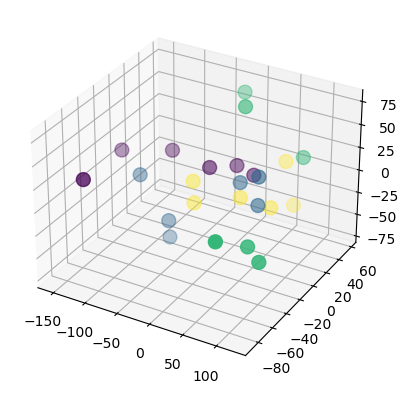

In [212]:
# pca plot of X, colored based on y
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_class, cmap='viridis', s=100)

plt.show()



## 2.1 Dummy classifier

In [213]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


clf_dummy = DummyClassifier( strategy='stratified')

skf = RepeatedKFold(n_splits=10, n_repeats=100)

scores_dummy = cross_val_score(clf_dummy, X, y, cv=skf, scoring='accuracy')

print(np.mean(scores_dummy), scores_dummy.std())


0.22866666666666666 0.2722139681288314


(array([535.,   0.,   0., 164.,   0., 226.,  42.,   0.,   0.,  33.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

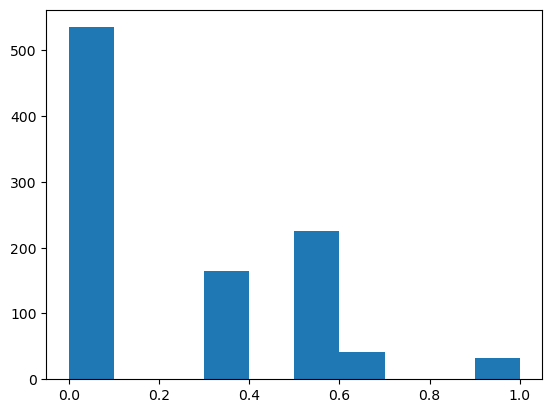

In [214]:
# histogram of res
plt.hist(scores_dummy, bins=10)

## 2.2 Classification using SVM

In [215]:
from sklearn import svm
from sklearn.model_selection import train_test_split

from numpy import ravel


clf = svm.SVC(kernel='linear', C=1, random_state=42)

skf = RepeatedKFold(n_splits=10, n_repeats=100)

scores = cross_val_score(clf, X, ravel(y), cv=skf, scoring='accuracy')

print(scores.mean(), scores.std())

0.8626666666666667 0.24760093340337438


(array([535.,   0.,   0., 164.,   0., 226.,  42.,   0.,   0.,  33.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

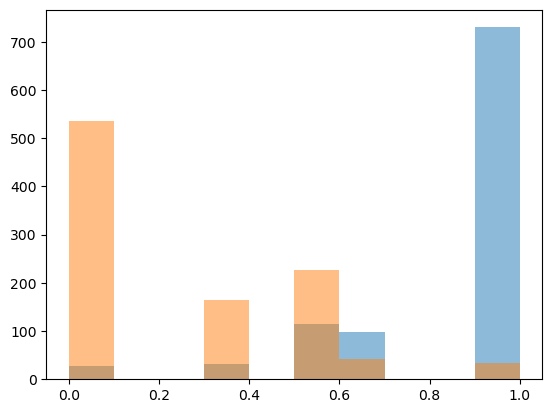

In [216]:
# histogram of scores and scores_dummy with different colors
plt.hist(scores, bins=10, alpha=0.5, label='SVM')
plt.hist(scores_dummy, bins=10, alpha=0.5, label='Dummy')

## 2.3. Leave one group out

In [217]:

from sklearn import svm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
logo.get_n_splits(X, y_class, run_class)


clf = svm.SVC(kernel='linear')

scores = cross_val_score(clf, 
                         X, 
                         ravel(y), 
                         cv=logo, 
                         groups=run_class, 
                         scoring='accuracy')

print(f'mean accuracy {np.mean(scores)} and std {scores.std()}')




mean accuracy 0.9583333333333334 and std 0.05892556509887896


[[6 0 0 0]
 [0 6 0 0]
 [0 0 6 0]
 [0 1 0 5]]


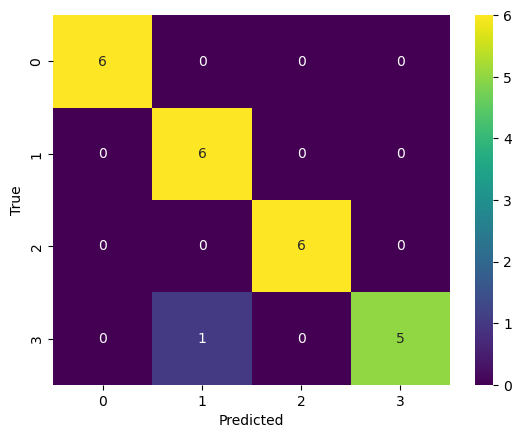

In [218]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, X, ravel(y), cv=logo, groups=run_class)

conf_mat = confusion_matrix(ravel(y), y_pred)

print(conf_mat)

# plot the confusion matrix
import seaborn as sns

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()


In [219]:
# skf = RepeatedRepeatedStratifiedKFoldKFold(n_splits=2, n_repeats=100)

In [220]:
for i, (train_index, test_index) in enumerate(logo.split(X, y_class, run_class)):
    
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={np.array(run_class)[train_index]}")
    print(f"  Test:  index={test_index}, group={np.array(run_class)[test_index]}")


Fold 0:
  Train: index=[ 2  3  4  5  8  9 10 11 14 15 16 17 20 21 22 23], group=[2. 2. 3. 3. 2. 2. 3. 3. 2. 2. 3. 3. 2. 2. 3. 3.]
  Test:  index=[ 0  1  6  7 12 13 18 19], group=[1. 1. 1. 1. 1. 1. 1. 1.]
Fold 1:
  Train: index=[ 0  1  4  5  6  7 10 11 12 13 16 17 18 19 22 23], group=[1. 1. 3. 3. 1. 1. 3. 3. 1. 1. 3. 3. 1. 1. 3. 3.]
  Test:  index=[ 2  3  8  9 14 15 20 21], group=[2. 2. 2. 2. 2. 2. 2. 2.]
Fold 2:
  Train: index=[ 0  1  2  3  6  7  8  9 12 13 14 15 18 19 20 21], group=[1. 1. 2. 2. 1. 1. 2. 2. 1. 1. 2. 2. 1. 1. 2. 2.]
  Test:  index=[ 4  5 10 11 16 17 22 23], group=[3. 3. 3. 3. 3. 3. 3. 3.]


In [221]:
# Get weights of the features
clf.fit(X, y)

mean_feature_coef = np.sum(np.abs(clf.coef_), 0)

mean_feature_coef

/Users/brunoleitao/anaconda3/envs/MNE-NIRS/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.01178424, 0.00597006, 0.00913722, 0.00762379, 0.01020837,
       0.0144657 , 0.00531208, 0.01757502, 0.01562393, 0.00571541,
       0.00842498, 0.01538162, 0.01477371, 0.01588613, 0.02027819,
       0.01472553, 0.01913897, 0.0128578 , 0.02008751, 0.01157089,
       0.01898708, 0.00937272, 0.00425742, 0.0073412 , 0.01597445,
       0.01726733, 0.00586684, 0.01553318, 0.01543554, 0.00773468,
       0.00810057, 0.01365433, 0.00713673, 0.0189103 , 0.0201049 ,
       0.01911697, 0.01711385, 0.01150489, 0.01170069, 0.0087776 ,
       0.01008368, 0.00655624, 0.01019251, 0.01385395, 0.01183346,
       0.00991235, 0.00988245, 0.00830559, 0.01024162, 0.01443074,
       0.01117583, 0.00692084, 0.00546155, 0.01107506, 0.00861241,
       0.00367369, 0.00919194, 0.00367441, 0.00451165, 0.00644764,
       0.01439139, 0.00935021, 0.0111022 , 0.02000433, 0.00862617,
       0.01131778, 0.00974143, 0.01689486, 0.00470739, 0.00822192,
       0.01308337, 0.01394681, 0.01285686, 0.0062639 , 0.01582

In [222]:

sorted_idx = np.argsort(mean_feature_coef)


In [223]:
# sort channels based on the sorted indexes
sorted_channels = [channels[i] for i in sorted_idx]

sorted_channels


['S25_D23 hbr',
 'S10_D7 hbr',
 'S19_D16 hbr',
 'S8_D6 hbr',
 'S27_D25 hbr',
 'S18_D18 hbo',
 'S19_D15 hbo',
 'S27_D23 hbo',
 'S31_D2 hbr',
 'S27_D5 hbo',
 'S15_D10 hbr',
 'S8_D8 hbo',
 'S15_D13 hbr',
 'S19_D16 hbo',
 'S15_D12 hbr',
 'S31_D27 hbr',
 'S25_D25 hbr',
 'S23_D9 hbo',
 'S25_D23 hbo',
 'S12_D7 hbr',
 'S14_D9 hbr',
 'S10_D10 hbr',
 'S3_D1 hbo',
 'S20_D16 hbr',
 'S17_D18 hbo',
 'S7_D5 hbr',
 'S20_D15 hbr',
 'S4_D3 hbo',
 'S14_D12 hbr',
 'S29_D25 hbr',
 'S9_D23 hbo',
 'S18_D18 hbr',
 'S1_D2 hbo',
 'S1_D2 hbr',
 'S31_D28 hbr',
 'S10_D6 hbr',
 'S19_D15 hbr',
 'S24_D21 hbo',
 'S20_D15 hbo',
 'S29_D25 hbo',
 'S3_D1 hbr',
 'S4_D3 hbr',
 'S14_D9 hbo',
 'S22_D22 hbr',
 'S27_D26 hbr',
 'S17_D15 hbo',
 'S11_D11 hbo',
 'S21_D21 hbr',
 'S4_D2 hbr',
 'S9_D5 hbo',
 'S18_D15 hbr',
 'S1_D28 hbr',
 'S32_D27 hbr',
 'S24_D24 hbr',
 'S19_D14 hbr',
 'S28_D24 hbo',
 'S2_D1 hbo',
 'S10_D8 hbo',
 'S27_D5 hbr',
 'S20_D17 hbr',
 'S2_D4 hbr',
 'S10_D10 hbo',
 'S23_D19 hbo',
 'S24_D21 hbr',
 'S16_D13 hbr'

In [224]:
# get hbo channels from channels
hbo_channels = df_features_M[df_features_M['ch_name'].str.contains('hbo')]['ch_name'].unique()

print(hbo_channels)

# Get the mean_feature_coef for hbo channels
mean_feature_coef_hbo = mean_feature_coef[[channels.tolist().index(ch) for ch in hbo_channels]]

['S1_D1 hbo' 'S1_D2 hbo' 'S1_D28 hbo' 'S2_D1 hbo' 'S2_D2 hbo' 'S2_D4 hbo'
 'S3_D1 hbo' 'S3_D4 hbo' 'S4_D2 hbo' 'S4_D3 hbo' 'S4_D5 hbo' 'S4_D26 hbo'
 'S5_D3 hbo' 'S5_D4 hbo' 'S5_D6 hbo' 'S6_D4 hbo' 'S7_D3 hbo' 'S7_D5 hbo'
 'S7_D6 hbo' 'S7_D7 hbo' 'S8_D4 hbo' 'S8_D6 hbo' 'S8_D8 hbo' 'S9_D5 hbo'
 'S9_D7 hbo' 'S9_D9 hbo' 'S9_D23 hbo' 'S10_D6 hbo' 'S10_D7 hbo'
 'S10_D8 hbo' 'S10_D10 hbo' 'S11_D8 hbo' 'S11_D11 hbo' 'S12_D7 hbo'
 'S12_D9 hbo' 'S12_D10 hbo' 'S12_D12 hbo' 'S13_D8 hbo' 'S13_D10 hbo'
 'S13_D11 hbo' 'S13_D13 hbo' 'S14_D9 hbo' 'S14_D12 hbo' 'S14_D19 hbo'
 'S15_D10 hbo' 'S15_D12 hbo' 'S15_D13 hbo' 'S15_D14 hbo' 'S16_D11 hbo'
 'S16_D13 hbo' 'S17_D14 hbo' 'S17_D15 hbo' 'S17_D18 hbo' 'S18_D15 hbo'
 'S18_D17 hbo' 'S18_D18 hbo' 'S19_D14 hbo' 'S19_D15 hbo' 'S19_D16 hbo'
 'S20_D15 hbo' 'S20_D16 hbo' 'S20_D17 hbo' 'S21_D18 hbo' 'S21_D19 hbo'
 'S21_D20 hbo' 'S21_D21 hbo' 'S22_D20 hbo' 'S22_D22 hbo' 'S23_D9 hbo'
 'S23_D19 hbo' 'S23_D21 hbo' 'S23_D23 hbo' 'S24_D20 hbo' 'S24_D21 hbo'
 'S24_D22 

In [225]:
# get hbr channels from channels
hbr_channels = df_features_M[df_features_M['ch_name'].str.contains('hbr')]['ch_name'].unique()

print(hbr_channels)

# Get the mean_feature_coef for hbo channels
mean_feature_coef_hbr = mean_feature_coef[[channels.tolist().index(ch) for ch in hbr_channels]]

['S1_D1 hbr' 'S1_D2 hbr' 'S1_D28 hbr' 'S2_D1 hbr' 'S2_D2 hbr' 'S2_D4 hbr'
 'S3_D1 hbr' 'S3_D4 hbr' 'S4_D2 hbr' 'S4_D3 hbr' 'S4_D5 hbr' 'S4_D26 hbr'
 'S5_D3 hbr' 'S5_D4 hbr' 'S5_D6 hbr' 'S6_D4 hbr' 'S7_D3 hbr' 'S7_D5 hbr'
 'S7_D6 hbr' 'S7_D7 hbr' 'S8_D4 hbr' 'S8_D6 hbr' 'S8_D8 hbr' 'S9_D5 hbr'
 'S9_D7 hbr' 'S9_D9 hbr' 'S9_D23 hbr' 'S10_D6 hbr' 'S10_D7 hbr'
 'S10_D8 hbr' 'S10_D10 hbr' 'S11_D8 hbr' 'S11_D11 hbr' 'S12_D7 hbr'
 'S12_D9 hbr' 'S12_D10 hbr' 'S12_D12 hbr' 'S13_D8 hbr' 'S13_D10 hbr'
 'S13_D11 hbr' 'S13_D13 hbr' 'S14_D9 hbr' 'S14_D12 hbr' 'S14_D19 hbr'
 'S15_D10 hbr' 'S15_D12 hbr' 'S15_D13 hbr' 'S15_D14 hbr' 'S16_D11 hbr'
 'S16_D13 hbr' 'S17_D14 hbr' 'S17_D15 hbr' 'S17_D18 hbr' 'S18_D15 hbr'
 'S18_D17 hbr' 'S18_D18 hbr' 'S19_D14 hbr' 'S19_D15 hbr' 'S19_D16 hbr'
 'S20_D15 hbr' 'S20_D16 hbr' 'S20_D17 hbr' 'S21_D18 hbr' 'S21_D19 hbr'
 'S21_D20 hbr' 'S21_D21 hbr' 'S22_D20 hbr' 'S22_D22 hbr' 'S23_D9 hbr'
 'S23_D19 hbr' 'S23_D21 hbr' 'S23_D23 hbr' 'S24_D20 hbr' 'S24_D21 hbr'
 'S24_D22 

## 2.4 RandomForest

In [226]:

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
logo.get_n_splits(X, y_class, run_class)


clf = RandomForestClassifier(max_depth=None, random_state=0)

# X = np.random.rand(X.shape[0], X.shape[1])

scores = cross_val_score(clf, X, ravel(y), cv=logo, groups=run_class, scoring='accuracy')

print(np.mean(scores), scores.std())


0.8333333333333334 0.05892556509887896


In [227]:
scores

array([0.875, 0.75 , 0.875])

[[0.83333333 0.         0.16666667 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.16666667 0.83333333 0.        ]
 [0.16666667 0.16666667 0.         0.66666667]]


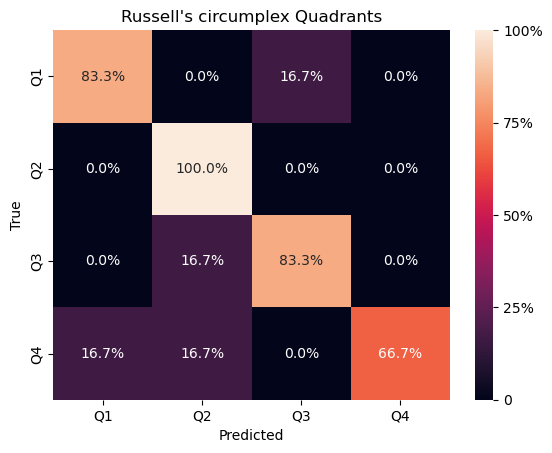

In [228]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, X, ravel(y), cv=logo, groups=run_class)

conf_mat = confusion_matrix(ravel(y), y_pred, normalize='true')

print(conf_mat)

# plot the confusion matrix
import seaborn as sns

q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
ax = sns.heatmap(conf_mat, annot=True, 
            fmt='.1%', 
            xticklabels=q_labels, 
            yticklabels=q_labels, vmin=0, vmax=1)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.5, .75, 1])
cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])

plt.xlabel('Predicted')
plt.ylabel('True')

# title
plt.title('Russell\'s circumplex Quadrants')

plt.show()

### 2.4.1 interpretation of weights

In [229]:
clf.fit(X, ravel(y))

RandomForestClassifier(random_state=0)

In [230]:
feature_importance = clf.feature_importances_

# max min scale the feature_importance
print(np.max(feature_importance), np.min(feature_importance))

0.04162251509362359 0.0


In [231]:
topnfeats  = 10
sorted_idx = np.argsort(np.abs(feature_importance))[::-1][:topnfeats]

# sort channels based on the sorted indexes
sorted_channels = [channels[i] for i in sorted_idx]

sorted_channels

['S8_D4 hbr',
 'S2_D4 hbo',
 'S25_D24 hbr',
 'S21_D21 hbo',
 'S7_D3 hbr',
 'S27_D23 hbr',
 'S24_D22 hbr',
 'S6_D4 hbr',
 'S22_D22 hbr',
 'S9_D9 hbr']

In [232]:
# get hbo channels from channels
hbo_channels = df_features_M[df_features_M['ch_name'].str.contains('hbo')]['ch_name'].unique()

# Get the mean_feature_coef for hbo channels
mean_feature_coef_hbo = feature_importance[[channels.tolist().index(ch) for ch in hbo_channels]]


In [233]:
# get hbr channels from channels
hbr_channels = df_features_M[df_features_M['ch_name'].str.contains('hbr')]['ch_name'].unique()


# Get the mean_feature_coef for hbo channels
mean_feature_coef_hbr = feature_importance[[channels.tolist().index(ch) for ch in hbr_channels]]



# 3. Analyze results

In [234]:
# import raw snirf to get channel montage

# Participant id.
p_id = 'S01'

# write data_path using p_id.
data_path = os.path.join('..', 'data', p_id, 'nirs')

print(data_path)

# Run id.
run_id = '1'


# Create an empty list to store the raw intensity data
raw_intensity = []

# Get files with .snirf extension using os
snirf_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.snirf')]

# select file that contains run_id in its name
snirf_file = [f for f in snirf_files if run_id in f]

if snirf_file:
    # Load the data in snirf_file
    raw_data = mne.io.read_raw_snirf(snirf_file[0], preload=True, verbose=True)

    raw_data.load_data()

else:
    
    print('No snirf file found')

raw_data.info

# Convert NIRS raw data to optical density.
raw_od = mne.preprocessing.nirs.optical_density(raw_data)

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6.0)


../data/S01/nirs
Loading /Users/brunoleitao/Documents/GitHub/NIRS-UCP/scripts/../data/S01/nirs/sub-S01_task-music_run-1.snirf
Reading 0 ... 2445  =      0.000 ...   194.133 secs...


In [235]:
data = mne.io.read_raw_fif('../data/derivatives/mne-nirs/S01/sub-S01_run-1_long_haemo.fif')

Opening raw data file ../data/derivatives/mne-nirs/S01/sub-S01_run-1_long_haemo.fif...
    Range : 26 ... 2283 =      2.064 ...   181.270 secs
Ready.


/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_55703/651032735.py:1: RuntimeWarning: This filename (../data/derivatives/mne-nirs/S01/sub-S01_run-1_long_haemo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif('../data/derivatives/mne-nirs/S01/sub-S01_run-1_long_haemo.fif')


In [236]:
# Download anatomical locations
subjects_dir = os.path.join(mne.datasets.sample.data_path(), 'subjects')
mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

identity_trans = mne.transforms.Transform("head", "mri")


0 files missing from root.txt in /Users/brunoleitao/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/brunoleitao/mne_data/MNE-sample-data/subjects/fsaverage


In [237]:
import mne

brain = mne.viz.Brain('fsaverage', 
                      subjects_dir=subjects_dir, 
                      background='w', 
                      cortex='.5',
                    title='NIRS channels',
);

brain.add_sensors(data.info, 
                  trans=identity_trans, 
                  fnirs=['channels', 'pairs', 'sources', 'detectors'],)

brain.show_view(azimuth=90, elevation=0, distance=450)

# save the brain plot
#brain.save_image('brain_hor_plot.png')


#brain.add_sensors(raw_data.info, trans="fsaverage", fnirs=["channels", "pairs"])

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Channel types::	hbo: 96, hbr: 96


import pyvista as pv
from pyvistaqt import BackgroundPlotter

p = BackgroundPlotter()
p.add_mesh(pv.Cone())

In [238]:

## This function is working for plotting source and detector pairs (106 channels) in 3D head model
fig = mne.viz.create_3d_figure(size=(800, 600), bgcolor='white')

surfaces=dict(brain=0.4, outer_skull=0.6, head=None)

fig = mne.viz.plot_alignment(data.info, 
                             trans=identity_trans,
                             subject='fsaverage',
                             coord_frame='mri',
                             surfaces=surfaces,
							 fnirs=['channels', 'pairs',
									'sources', 'detectors'],
                             fig=fig)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using outer_skin.surf for head surface.
Channel types::	hbo: 96, hbr: 96


In [239]:
# create a random array of 268 values
#t_data = np.random.rand(98)

In [240]:
# select only hbo channels

# Return channels with a long source detector separation.
long_haemo = mne_nirs.channels.get_long_channels(raw_haemo)



In [241]:
hbo_ch=long_haemo.pick(picks='hbo')


In [242]:
hbo_ch_plot=hbo_ch.ch_names

# create a copy hbo_ch_plot
hbo_ch_plot_copy = hbo_ch_plot.copy()

# if any element of sorted_channels is NOT in hbo_ch_plot_copy replace it with ' '
for i, ch in enumerate(hbo_ch_plot_copy):
    if ch not in sorted_channels:
        hbo_ch_plot_copy[i] = ' '

# remove the last token from the channel names
hbo_ch_plot_copy = [ch[:-3] for ch in hbo_ch_plot_copy]

<Figure size 1000x1000 with 0 Axes>

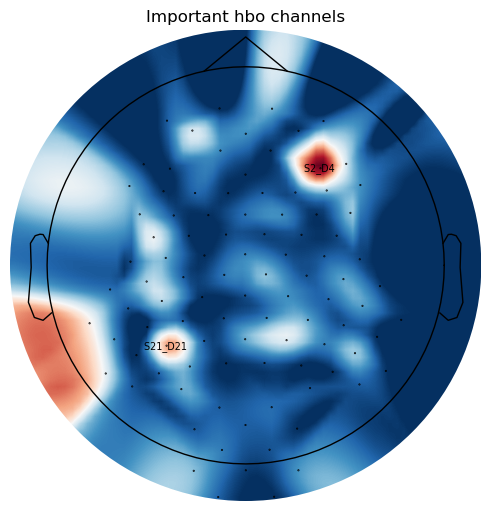

In [243]:
# Set the size of the figure

import matplotlib


fig = plt.figure(figsize=(10, 10))


im, _ = mne.viz.plot_topomap(mean_feature_coef_hbo, 
                     hbo_ch.info,
                     sensors=True,
                     outlines='head', 
                     contours=0,
                     sphere=0.12,
                     cmap='RdBu_r', 
                     size=5, 
                     names=hbo_ch_plot_copy,
                     show=False,
                     )

plt.title('Important hbo channels')



plt.show()

